# Unicornn


In [2]:
import librosa
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from sklearn.metrics import confusion_matrix
import collections
from torchsummary import summary
from tqdm import tqdm
from Models.VGG import VGG
from Models.ResNet import ResNet

## Params
Die hier aufgelisteten Parameter ermöglichen die wichtigsten Einstellungen.

In [6]:
# Generel Params
durationOfAudioSample = 1   # Length of AudioSamples for Training
showDataBalance = True      # Shows Data Balance in the complete and the splitted Datasets. (time intensive)

modelType = "ResNet"        # "VGG" or "ResNet"
optimizerType = "Adam"      # "Adam" or "SGD"
load = None                 # "best" or "last"
batchSize = 128             # Batch size for Training
epochs= 20                # Number of Epochs for Training
learningRate = 0.0001       # Learning Rate

# Checks if gpu is available
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Device:", device)

random.seed(0)              
torch.manual_seed(0)

Device: cuda:0


## Utils

Im Folgenden werden zunächst einige Hilfsfunktionen erstellt.

### Wave2Image

In [ ]:
def wave2image(file):
    samples, sample_rate = librosa.core.load(file,sr=16000)

    # correct length of audiosample to fix length
    fixed_sample_length = int(durationOfAudioSample * sample_rate)
    
    if fixed_sample_length < len(samples):      #truncate
        samples = samples[:fixed_sample_length]
    elif fixed_sample_length > len(samples):    # add silence
        samples = np.pad(samples, (0, fixed_sample_length - len(samples)), "constant")

    # Create MelSpectrum
    s = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=32)
    mel = librosa.power_to_db(s, ref=np.max)

    return mel

### Show Image

Die Funktion `show(image,title = None)` ermöglicht das Plotten von Bildern.
Das Argument `title` ist optional und kann z.B. für das entsprechende Label verwendet werden.

In [ ]:
def show(_image, _title = None):
    plt.figure(figsize=(15, 5))
    plt.imshow(_image[0])

    if _title is not None:
        plt.title(_title)
    
    plt.colorbar()
    plt.show()

### Count Labels in Dataset

Die Funktion `dataBalance` zählt wie oft ein Label im Datensatz vorkommt und gibt die Werte
als Liste zurück. Der Index in der Liste entspricht dabei dem Label (erster Eintrag
entspricht der absoluten Häufigkeit von Label 0 im Datensatz, der darauf folgende Wert Label 1 usw.).

In [ ]:
def dataBalance(_dataset):
    _y = [y for _,y,_ in _dataset]
    _counter = collections.Counter(_y)

    _sizes = []

    for i in range(0, len(_counter)):
        _sizes.append(_counter[i])

    return _sizes

## Dataset

Die Klasse `CommandDataset` representiert den kompletten Datensatz.

In der `__init__(self)` Funktion werden alle Pfade zu Daten
vereint und die entsprechenden Labels erstellt.

Die Funktion `__len__(self)` gibt die Anzahl der Einträge im Datensatz an.

Der Zugriff auf Datensatzeinträge erfolgt ähnlich wie bei Listen
oder Arrays (`dataset[idx]` gibt den `idx`-ten Eintrag zurück).
Dabei wird die Klasse `__getItem__(self,idx)` aufgerufen, in welcher der
`idx`-te Eintrag erstellt wird. Die Rückgabe besteht aus dem Bild des MelSpektrograms, dem Label,
sowie dem Pfad zur Wave-Datei.

Einträge im Datensatz: 57348
Random Element: Dataset/data-speech_commands_v0.02/three/a7acbbeb_nohash_0.wav


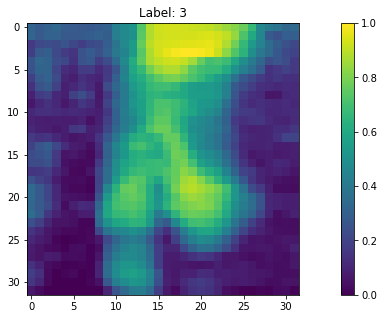

In [ ]:
class CommandDataset(torch.utils.data.Dataset):

    def __init__(self):
        paths = ["Dataset/data-speech_commands_v0.02/zero/",
                 "Dataset/data-speech_commands_v0.02/one/",
                 "Dataset/data-speech_commands_v0.02/two/",
                 "Dataset/data-speech_commands_v0.02/three/",
                 "Dataset/data-speech_commands_v0.02/four/",
                 "Dataset/data-speech_commands_v0.02/five/",
                 "Dataset/data-speech_commands_v0.02/six/",
                 "Dataset/data-speech_commands_v0.02/seven/",
                 "Dataset/data-speech_commands_v0.02/eight/",
                 "Dataset/data-speech_commands_v0.02/nine/",

                 "Dataset/data-speech_commands_v0.02/forward/",
                 "Dataset/data-speech_commands_v0.02/backward/",
                 "Dataset/data-speech_commands_v0.02/left/",
                 "Dataset/data-speech_commands_v0.02/right/",
                 "Dataset/data-speech_commands_v0.02/up/",
                 "Dataset/data-speech_commands_v0.02/down/"
                 ]

        self.classes = len(paths)

        self.datasetItems = []
        self.exampleIDs = []
        _id = -1
        
        for _label in range(0,len(paths)):
            for filename in os.listdir(paths[_label]):
                if filename.endswith(".wav"):
                    self.datasetItems.append((os.path.join(paths[_label],filename),_label))
                    _id += 1
            self.exampleIDs.append(_id)

    def __len__(self):
        return len(self.datasetItems)

    def __getitem__(self, idx):
        _image = wave2image(self.datasetItems[idx][0])

        # scale to Range[0;1]
        _min = np.min(_image)
        _image -= _min
        _max = np.max(_image)
        _image /=_max

        return torch.Tensor(_image).unsqueeze(0), self.datasetItems[idx][1], self.datasetItems[idx][0]

commandDataset = CommandDataset()
print("Einträge im Datensatz:", len(commandDataset))

random_idx = random.randint(0, len(commandDataset)-1)
image, label, path = commandDataset[random_idx]
print("Random Element:", path)
show(image,"Label: " + str(label))

Class Examples:


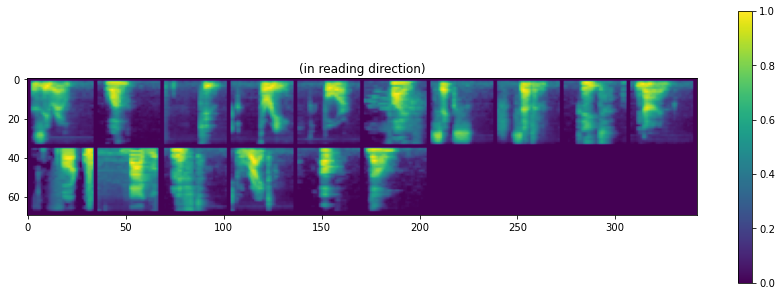

In [ ]:
print("Class Examples:")
grid = [commandDataset[i][0] for i in commandDataset.exampleIDs]

grid = torchvision.utils.make_grid(grid, nrow=10, padding=2)
show(grid.numpy(), "(in reading direction)")

### Splitting

Um den Trainingsprozess später evaluieren zu können wird der Datasatz in einen
Trainings- und einen Evaluierungsdatensatz aufgeteilt. Das Verhältnis zwischen den
beiden Datensätzen ist 80:20.

In [ ]:
len_ds = len(commandDataset)
len_train = int(0.8*len_ds)
len_val = len_ds - len_train

train_ds, val_ds = torch.utils.data.random_split(commandDataset,[len_train,len_val])

print("Trainingsdaten:", len(train_ds))
print("Evaluierungsdaten:", len(val_ds))

Trainingsdaten: 45878
Evaluierungsdaten: 11470


### Balance in Datasets

Im Folgenden wird die Verteilung der Einträge nach Label in den verschiedenen Datensätzen
visuell verglichen. Da der Prozess relativ rechenaufwendig ist, kann dieser Abschnitt
übersprungen werden indem die Variable `showDataBalance` auf `False` gesetzt wird.

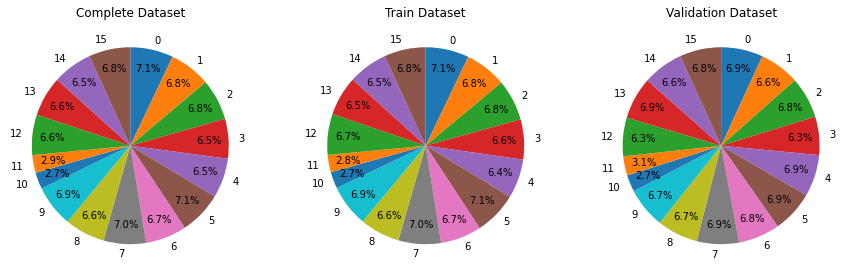

In [ ]:
if showDataBalance == True:
    complete_balance = dataBalance(commandDataset)
    train_balance = dataBalance(train_ds)
    val_balance = dataBalance(val_ds)

    pie_labels = np.arange(commandDataset.classes)

    if len(train_balance) < commandDataset.classes or len(val_balance) < commandDataset.classes:
        print("Datensatz ist zu klein für zufälligen Splitt.\nNicht alle Klassen sind im Train und Test Splitt vertretten.")
    else:
        plt.figure(figsize=(15, 5))
        plt.subplot(131)
        plt.pie(complete_balance, labels=pie_labels, counterclock=False, autopct='%1.1f%%',startangle=90,pctdistance=0.8)
        plt.title("Complete Dataset")
        plt.subplot(132)
        plt.pie(train_balance, labels=pie_labels, counterclock=False, autopct='%1.1f%%',startangle=90,pctdistance=0.8)
        plt.title("Train Dataset")
        plt.subplot(133)
        plt.pie(val_balance, labels=pie_labels, counterclock=False, autopct='%1.1f%%',startangle=90,pctdistance=0.8)
        plt.title("Validation Dataset")
        plt.show()
else:
    print("Inorder to plot data balance set showDateBalance=True.")

### DataLoader

`DataLoader` bilden aus den Einträgen in einem Datensatz Batches. Durch `shuffle=True` werden
die Batches aus zufälligen Datensatzeinträgen zusammengestellt. Die Größe der Batches wird durch die Variable
`batchSize` angegeben.

In [ ]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batchSize, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=batchSize, shuffle=True)

print("Batches im Trainingsdatensatz:",len(train_dl))
print("Batches im Evaluierungsdatensatz:",len(val_dl))

Batches im Trainingsdatensatz: 359
Batches im Evaluierungsdatensatz: 90


## Model

In [ ]:
if modelType == "VGG":
    model = VGG.VGG(commandDataset.classes)
elif modelType == "ResNet":
    #model = torchvision.models.resnet34()
    #model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model = ResNet.ResNet(commandDataset.classes)
else:
    print("Unknown Model")

if not os.path.exists("Weights/"):
        os.mkdir("Weights/")

if load == "best":
    model.load_state_dict(torch.load("Weights/bestWeights_" + modelType + "_" + optimizerType + ".pth"))
    print("Loaded best Weights!")

if load == "last":
    model.load_state_dict(torch.load("Weights/lastWeights_" + modelType + "_" + optimizerType + ".pth"))
    print("Loaded last Weights!")

model = model.to(device)
summary(model, (1,32,32))
# print(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           3,136
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

## Training

### Loss-Funktion

Für Multi-Class-Image-Classification wird oft das CrossEntropyLoss verwendet. Pro Batch wird ein
Durchschnittswert berechnet.

In [3]:
loss_func = nn.CrossEntropyLoss(reduction="mean")
loss_hist = []
loss_hist_eval = []

### Metrik

Als Metrik wird pro Batch der prozentuale Anteil der Fälle, in denen die Klassifizierung erfolgreich war,
angegeben.

In [4]:
acc_func = lambda y_real, y_pred:(y_real == y_pred.argmax(1)).sum().item() # /batchSize
acc_hist = []
acc_hist_eval = []

### Confusion-Matrix

Diese Funktionen dienen dazu, die Confusion-Matrix zu erstellen und zu plotten. Die Diagonale der Matrix stellt die
Anzahl der richtig ermittelten Klassen dar.

In [ ]:
labels = []
predictions = []

def create_confusion_matrix(_labels, _predictions):
  label_names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
  cmx = confusion_matrix(_labels, _predictions, labels=label_names)

  plt.imshow(cmx)
  title = modelType + ' & ' + optimizerType
  plt.title(title)
  plt.xticks(rotation=50)
  plt.xticks(range(0, 16), ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'forward', 'backward', 'left', 'right', 'up', 'down'])
  plt.yticks(range(0, 16), ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'forward', 'backward', 'left', 'right', 'up', 'down'])
  plt.colorbar()
  plt.show()

### Optimizer

In [ ]:
if optimizerType == "Adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
elif optimizerType == "SGD":
    optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
else:
    print("No valid optimizer.")


### Learning Rate optimierung

Anpassen der LearningRate während des Trainings.

In [ ]:
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.1)

### Train-Loop

100%|██████████| 90/90 [00:36<00:00,  2.48it/s]



Epoche:  0 [LR: 0.0001 ]
Accuracy (Train): 32150/45878 (0.7008)
Loss Batch (Train): 1.1395327326813116
Accuracy (Eval): 9308/11470 (0.8115)
Loss Batch (Eval): 0.580133632156584
Best weights after epoch 0


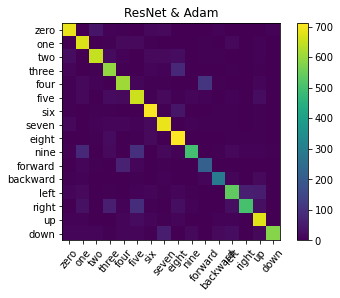

In [ ]:
best_loss = float("inf")

for e in range(0,epochs):
    print("\nEpoche: ", e, "[LR:", optimizer.param_groups[0]['lr'] ,"]")
    accuracy = 0
    loss_epoch = 0

    for x, y_real, _ in tqdm(train_dl):
        model.train()
        y_pred = model(x.to(device))

        # print("Real-Label:", y_real)
        # print("Pred-Label:", y_pred.argmax(1))

        accuracy += acc_func(y_real, y_pred.detach().cpu())

        loss = loss_func(y_pred, y_real.to(device))
        loss_epoch += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    acc_hist.append(accuracy/len(train_ds))
    print("Accuracy (Train): {0:d}/{1:d} ({2:.4f})".format(int(accuracy), len(train_ds), accuracy/len(train_ds)))
    loss_hist.append(loss_epoch/len(train_dl))
    print("Loss Batch (Train):", loss_epoch/len(train_dl))

    model.eval()
    
    with torch.no_grad():
        accuracy = 0
        loss_epoch = 0

        for x, y_real, _ in tqdm(val_dl):
            y_pred = model(x.to(device))

            labels += y_real.cpu().tolist()
            predictions += y_pred.argmax(1).cpu().tolist()

            accuracy += acc_func(y_real, y_pred.detach().cpu())
            acc_hist_eval.append(accuracy)

            loss = loss_func(y_pred,y_real.to(device))
            loss_epoch += loss.item()

        acc_hist_eval.append(accuracy / len(val_ds))
        print("Accuracy (Eval): {0:d}/{1:d} ({2:.4f})".format(int(accuracy), len(val_ds), accuracy / len(val_ds)))
        loss_hist_eval.append(loss_epoch / len(val_dl))
        print("Loss Batch (Eval):", loss_epoch / len(val_dl))

        if loss_epoch < best_loss:
            best_loss = loss_epoch
            torch.save(model.state_dict(),"Weights/bestWeights_" + modelType + "_" + optimizerType + ".pth")
            print("Best weights after epoch", e)

        lr_scheduler.step(metrics=loss_epoch)

    torch.save(model.state_dict(),"Weights/lastWeights_" + modelType + "_" + optimizerType + ".pth")

    cmx = create_confusion_matrix(labels, predictions)

    #empty out labels and predictions to fill with new values in next epoch
    labels.clear()
    predictions.clear()



### Loss- und Accuracy-Plot

(Aktuell: Loss und Accuracy der 3 durchlaufenen Batches.)

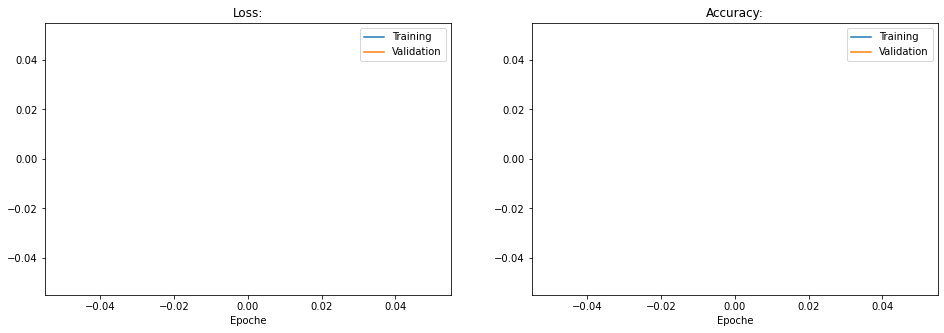

In [8]:
plt.figure(figsize=(16, 5))
plt.subplot(121)
plt.plot(loss_hist, label="Training")
plt.plot(loss_hist_eval, label="Validation")
plt.title('Loss:')
plt.legend()
plt.xlabel('Epoche')

plt.subplot(122)
plt.plot(acc_hist, label="Training")
plt.plot(acc_hist_eval, label="Validation")
plt.title('Accuracy:')
plt.xlabel('Epoche')
plt.legend()
plt.savefig("Loss_Acc_" + modelType + "_" + optimizerType + ".png")
plt.show()

### ONNX-Export

In [ ]:
model.load_state_dict(torch.load("Weights/bestWeights_" + modelType + "_" + optimizerType + ".pth"))
model = model.to(device)
model.eval()

dummy_input = torch.randn(16, 1, 32, 32, device=device)
torch.onnx.export(model, dummy_input, "Unicornn_" + modelType + "_" + optimizerType + ".onnx", verbose=True)

